# Digit Recognizer with Keras

In [1]:
import numpy as np
from random import randint
from sklearn.preprocessing import MinMaxScaler
import pandas as pd  
import os
import gzip
import io
import keras
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_labels = []
train_samples = []

path_train = os.getcwd() + '\data\\train.csv'  
train = pd.read_csv(path_train)

path_test = os.getcwd() + '\data\\test.csv' 
test_samples = pd.read_csv(path_test)


In [3]:
train.shape

(42000, 785)

In [4]:
test_samples.shape

(28000, 784)

In [5]:
np.random.shuffle(train.values)

train_labels = train['label']
train_samples = train.drop("label", axis=1)

train_labels_original = np.array(train_labels.values)
train_samples_original = np.array(train_samples.values)
test_samples_original = np.array(test_samples.values)

In [ ]:
train_samples = train_samples_original.reshape(train_samples_original.shape[0], 28, 28, 1)
test_samples = test_samples_original.reshape(test_samples_original.shape[0], 28, 28, 1)
train_labels = keras.utils.to_categorical(train_labels, 10)

train_samples = train_samples.astype("float32")
test_samples = test_samples.astype("float32")

Our dataset consists of 60000 images of handwritten numbers, each consisting of 28x28 black or white pixels.<br>
The images used are from the [MNIST handwritten digit database](http://yann.lecun.com/exdb/mnist/) and pulled from [kaggle](https://www.kaggle.com/c/digit-recognizer/data).<br>
I should note that all images are written by around 250 unique individuals which suggests that our model will overfit to their handwriting to some extend.

Checking for missing values:

In [81]:
np.where(np.isnan(train_samples_original))

(array([], dtype=int64), array([], dtype=int64))

In [82]:
np.where(np.isnan(train_labels_original))

(array([], dtype=int64),)

In [83]:
np.where(np.isnan(test_samples_original))

(array([], dtype=int64), array([], dtype=int64))

No missing values, great!

Now let's look at some of the images:

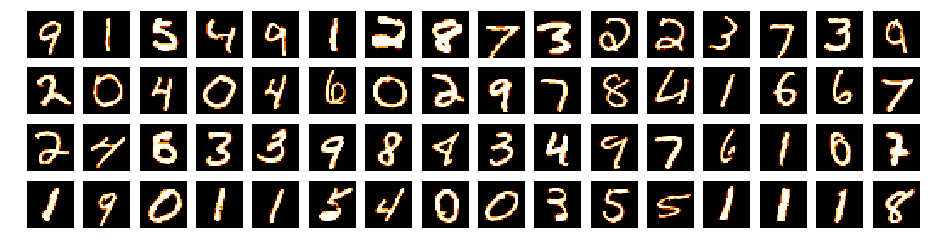

In [9]:
def display(img):
    
    # (784) => (28,28)
    image = img.reshape(28, 28)
    
    plt.axis('off')
    plt.imshow(image, cmap = "afmhot")

fig = plt.figure(figsize=(16, 4))

for i in range(64):
    fig.add_subplot(4,16,i+1)
    display(train_samples[i,:])  
    


Well, this is what i expected so that's good.

Let's see if there are any imbalances in our dataset (e.g. one number appears more often than the other):

<Container object of 10 artists>

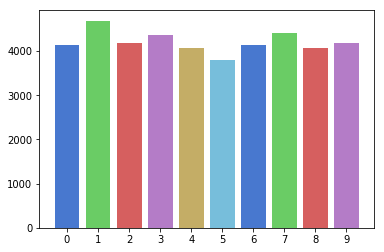

In [10]:
plt.bar(np.arange(10), sum(train_labels), tick_label=np.arange(10), color = sns.color_palette("muted", 10))

Seems balanced enough to me. No need to add class weights to the loss function.

Now we create our CNN using keras.<br>
Keras is a very high level language which makes it relatively easy to create a custom CNN.

In [ ]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *


In [151]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28, 1), activation="relu"))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))


In [152]:
model.compile(optimizer=keras.optimizers.Adadelta(), loss="categorical_crossentropy", metrics=["accuracy"])

In [156]:
model.fit(train_samples, 
          train_labels, 
          batch_size = 32, 
          validation_split = 0.0, 
          shuffle = True,
          epochs = 15, 
          verbose=2)

Epoch 1/15
 - 550s - loss: 0.1067 - acc: 0.9742
Epoch 2/15
 - 550s - loss: 0.0811 - acc: 0.9805
Epoch 3/15
 - 551s - loss: 0.0807 - acc: 0.9814
Epoch 4/15
 - 552s - loss: 0.0879 - acc: 0.9816
Epoch 5/15
 - 553s - loss: 0.0783 - acc: 0.9836
Epoch 6/15
 - 555s - loss: 0.0735 - acc: 0.9862
Epoch 7/15
 - 566s - loss: 0.0753 - acc: 0.9867
Epoch 8/15
 - 552s - loss: 0.0691 - acc: 0.9876
Epoch 9/15
 - 552s - loss: 0.0742 - acc: 0.9875
Epoch 10/15
 - 553s - loss: 0.0728 - acc: 0.9877
Epoch 11/15
 - 552s - loss: 0.0771 - acc: 0.9886
Epoch 12/15
 - 552s - loss: 0.0767 - acc: 0.9890
Epoch 13/15
 - 549s - loss: 0.0739 - acc: 0.9884
Epoch 14/15
 - 548s - loss: 0.0775 - acc: 0.9897
Epoch 15/15
 - 548s - loss: 0.0704 - acc: 0.9910


In [157]:
testfit = model.predict(test_samples)

In [158]:
prediction = np.argmax(testfit, axis=1)
c = np.arange(1, 28001)
result = np.c_[c, prediction]
np.savetxt("digit_recognizer_prediction_v1.csv",
          result,
          delimiter=",",
          header = "ImageId,Label",
          comments="",
          fmt="%d")


With a training time of around 5 minutes on my laptop my test set accuracy ended up being 98.8%. Since my validation error is 98.9% it's reasonable to think that our dropout layers work and we are not overfitting with our model. This puts me in the top 30% of the kaggle competition. But there is still a lot of fine tuning possible.

Let's look at the missclassified images in our validation data:

In [68]:
val_split = int(42000-0.2*42000)
validation_sample = train_samples[val_split:,:]
validation_predictions = model.predict_classes(validation_sample).reshape((-1,))
incorrects = np.nonzero(validation_predictions != train["label"][val_split:])

8400/8400 [==============================] - ETA: 0s


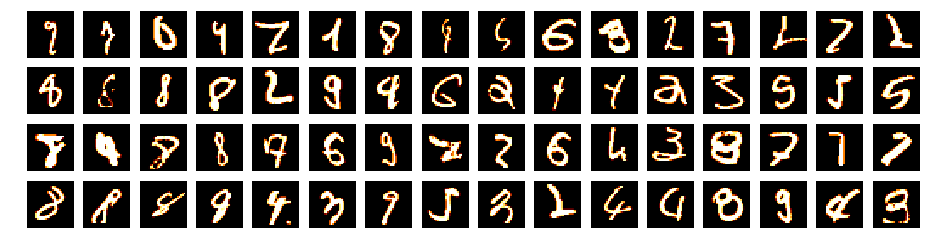

In [69]:
fig = plt.figure(figsize=(16, 4))
for i in range(min(64,len(incorrects[0]))):
    fig.add_subplot(4, 16, i+1)
    display(train_samples[val_split + incorrects[0][i],])

A lof of these numbers seem hard to classify, so that's fair. Finding patterns in the missclassified numbers could help us improve our model, so let's look at how often each digit in our validation set got missclassified:

Text(0.5,1,'Number of missclassifications by digit')

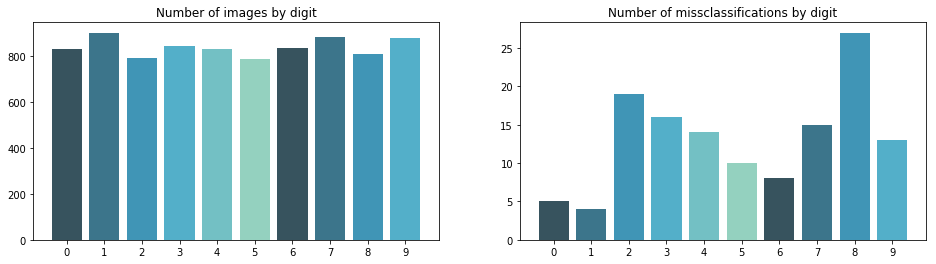

In [133]:
incorrect_by_number = np.zeros(10)

unique, counts = np.unique(train_labels_original[val_split:], return_counts=True)

for i in range(len(incorrects[0])):
    k = train["label"][val_split + incorrects[0][i]]
    incorrect_by_number[k] += 1

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(1, 2, 1)
plt.bar(unique, counts, tick_label=np.arange(10),color = sns.color_palette("GnBu_d"))
ax1.set_title("Number of images by digit")

ax2 = fig.add_subplot(1, 2, 2)
plt.bar(np.arange(0 ,10), incorrect_by_number, tick_label=np.arange(10),color = sns.color_palette("GnBu_d"))
ax2.set_title("Number of missclassifications by digit")

Let's make a simple Chi-Squared-Test to decide whether or not the distribution of missclassifications is to be expected:

In [136]:
from scipy.stats import chisquare

error_rate = len(incorrects[0])/(len(train_labels)-val_split)
expected_value_by_class = counts*error_rate
chisquare(incorrect_by_number, expected_value_by_class)

Power_divergenceResult(statistic=35.106716338212664, pvalue=5.7055209153437247e-05)

The p-value of our test statistic is very close to zero so it seems likely that our model has a hard time predicting eights and zeros and that is not just due to chance. 

If we remember our intuition behind CNNs that with every layer a CNN tends to pick up more and more complex structures of an images and that numbers like 2 and 8 have the same "basic" features (rounded edges and so on) but differ in the more complex arrangements of their features, then it makes me think that we need more layers instead of more filters.

In the end training our model longer will be much more important than the distinctions between filters and layers but it's still worth keeping in mind.

Every picture consists of 28*28 = 784 parameters. Compared to other image data sets that's not much but still enough that a dimensionality reduction technique like PCA is worth trying.

[Here](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579#140579) is a great explanation by amoeba as to how PCA works.

Let's start with..

### Calculating the Eigenvectors of the Covariance matrix

In [79]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
train_samples_original = train_samples_original.astype("float64")
train_std = StandardScaler().fit_transform(train_samples_original)

# Calculating Eigenvectors and eigenvalues of Covariance matrix
mean = np.mean(train_std, axis=0)
covariance_matrix = np.cov(train_std.T)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
eigenpairs = [(np.abs(eigenvalues[i]),eigenvectors[:,i]) for i in range(len(eigenvalues))]

eigenpairs.sort(key = lambda x: x[0], reverse= True)

# Calculating the explanied variance of each eigenvector
sum_of_eigenvalues = sum(eigenvalues)
explained_variance = [i/sum_of_eigenvalues for i in sorted(eigenvalues, reverse = True)]
cumulative_explained_variance = np.cumsum(explained_variance)

Now we take a look at the distribution of the explained variance of our data:

Text(319,0.88,'0.95 Quantil')

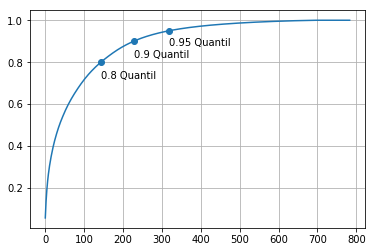

In [22]:
markers_on = [np.min(np.where(cumulative_explained_variance > 0.80)), np.min(np.where(cumulative_explained_variance > 0.90)), 
              np.min(np.where(cumulative_explained_variance > 0.95))]

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(cumulative_explained_variance, marker = "o", markevery=markers_on)

ax.grid()  
ax.annotate("0.8 Quantil", xy=(np.min(np.where(cumulative_explained_variance > 0.80)), 0.72))
ax.annotate("0.9 Quantil", xy=(np.min(np.where(cumulative_explained_variance > 0.90)), 0.82))
ax.annotate("0.95 Quantil", xy=(np.min(np.where(cumulative_explained_variance > 0.95)), 0.88))

225 variables is enough to account for roughly 90% of the explained variance of our model! Using PCA to reduce our model to the most influencial 225 variables seems like a good choice.

In [23]:
from sklearn.decomposition import PCA as sklearnPCA

pca = sklearnPCA(n_components=225)
train_225dim = pca.fit_transform(train_std)

In [24]:
train_225dim_reshaped = train_225dim.reshape(train_225dim.shape[0], 15, 15, 1)

In [54]:
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3), input_shape=(15, 15, 1), activation="relu"))
model2.add(Conv2D(32, (3,3), activation="relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(64, (3,3), activation="relu"))
model2.add(Dropout(0.25))
model2.add(Conv2D(64, (3,3), activation="relu"))
model2.add(Flatten())
#model2.add(Dense(32, activation='relu'))
model2.add(Dense(10, activation='softmax'))


In [55]:
model2.compile(optimizer=keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [56]:
model2.fit(train_225dim_reshaped, 
          train_labels, 
          batch_size = 30, 
          validation_split = 0.2, 
          shuffle = True,
          epochs = 20,
          verbose = 2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
 - 18s - loss: 0.8980 - acc: 0.7156 - val_loss: 0.3765 - val_acc: 0.8881
Epoch 2/20
 - 19s - loss: 0.4645 - acc: 0.8575 - val_loss: 0.2885 - val_acc: 0.9155
Epoch 3/20
 - 17s - loss: 0.3856 - acc: 0.8781 - val_loss: 0.2750 - val_acc: 0.9200
Epoch 4/20
 - 18s - loss: 0.3428 - acc: 0.8918 - val_loss: 0.2444 - val_acc: 0.9260
Epoch 5/20
 - 17s - loss: 0.3232 - acc: 0.8987 - val_loss: 0.2336 - val_acc: 0.9277
Epoch 6/20
 - 18s - loss: 0.3011 - acc: 0.9046 - val_loss: 0.2315 - val_acc: 0.9307
Epoch 7/20
 - 18s - loss: 0.2890 - acc: 0.9079 - val_loss: 0.2091 - val_acc: 0.9386
Epoch 8/20
 - 20s - loss: 0.2768 - acc: 0.9124 - val_loss: 0.2031 - val_acc: 0.9376
Epoch 9/20
 - 18s - loss: 0.2673 - acc: 0.9143 - val_loss: 0.1977 - val_acc: 0.9411
Epoch 10/20
 - 18s - loss: 0.2563 - acc: 0.9172 - val_loss: 0.2010 - val_acc: 0.9396
Epoch 11/20
 - 19s - loss: 0.2468 - acc: 0.9223 - val_loss: 0.1980 - val_acc: 0.9419
Epoch 12/20
 - 20s - loss

As we can see an epoch takes only a 10th of the time it did without PCA. However, our accuracy and especially our learning rate suffers as well and in the end this model does not ouperform our vanilla CNN from earlier.

If it turns out that our model has a good accuracy at the missclassified images from our first model maybe we can still recycle it by construct a committee of conv nets as our new classifier:

In [61]:
validation_sample = train_225dim_reshaped[val_split:,:]
validation_predictions2 = model2.predict_classes(validation_sample).reshape((-1,))
incorrects2 = np.nonzero(validation_predictions2 != train["label"][val_split:])

8400/8400 [==============================] - ETA: 0s


Now how did our second model do with the images our first model missclassified?

In [76]:
len(set(incorrects[0]).intersection(incorrects2[0]))/len(incorrects[0])

0.6717557251908397

Unfortunately it turns out our second model missclassified 67% of the images in our validation set that our first model missclassified. 

In the end it seems to be more effective to just use our original model and either use more epochs or a more complex neural net than using PCA to reduce dimensionality.